In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import random
from scipy.linalg import svd
from sklearn.utils.extmath import randomized_svd

## Read the data

In [2]:
# Read the file as a DataFrame
df = pd.read_csv("GSM5621018_Run5C_gene_exon_tagged_dge.txt", sep="\t")

In [3]:
genes = df["GENE"]
# Extract the expression data and convert it into a matrix
expression_matrix = df.iloc[:, 1:].values

# Print the gene names
print("Genes:", genes)

# Print the expression matrix
print("Expression Matrix:")
print(expression_matrix)

Genes: 0        0610005C13Rik
1        0610007N19Rik
2        0610007P14Rik
3        0610009B14Rik
4        0610009B22Rik
             ...      
18538         n-R5s205
18539         n-R5s219
18540          n-R5s40
18541          n-R5s88
18542          n-R5s89
Name: GENE, Length: 18543, dtype: object
Expression Matrix:
[[1 1 0 ... 0 0 0]
 [9 5 0 ... 0 0 0]
 [0 3 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [4]:
# Calculate the number of zeros in expression matrix
print("The shape of expression matrix is : " , expression_matrix.shape)
num_zeros = expression_matrix.size - np.count_nonzero(expression_matrix)
print("Number of zeros in X:", num_zeros)
zero_rate = num_zeros/expression_matrix.size
print('The sparsity of expression matrix is: ',zero_rate )

The shape of expression matrix is :  (18543, 4136)
Number of zeros in X: 74219713
The sparsity of expression matrix is:  0.967740111305929


## A simple Visualization

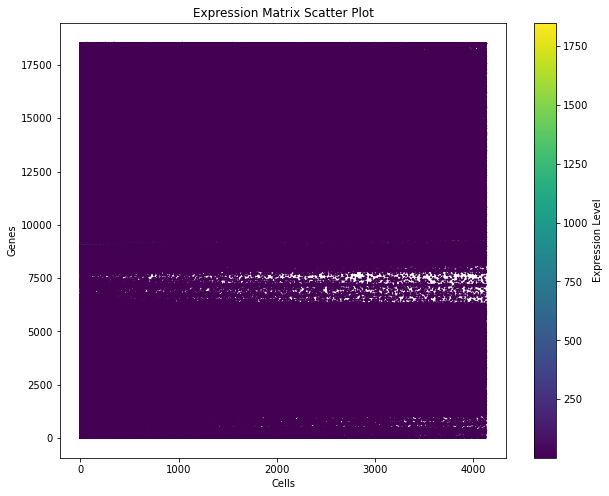

In [5]:
# Get the row and column indices of non-zero elements
non_zero_indices = np.nonzero(expression_matrix)

# Extract the non-zero values and their corresponding indices
non_zero_values = expression_matrix[non_zero_indices]
row_indices, col_indices = non_zero_indices

# Set the figure size
plt.figure(figsize=(10, 8))

# Create a scatter plot of non-zero values
plt.scatter(col_indices, row_indices, c=non_zero_values, cmap='viridis', s=1)
plt.colorbar(label='Expression Level')
plt.xlabel('Cells')
plt.ylabel('Genes')
plt.title('Expression Matrix Scatter Plot')
plt.show()

## Preprocessing: Filtering & Normalization

In [6]:
def filter_cells(expression_matrix, n_gene_threshold, n_cell_threshold):
    # Calculate the number of expressed genes per cell
    n_genes_per_cell = np.sum(expression_matrix > 0, axis=0)
    
    # Mask for cells that pass the nGene threshold
    cell_mask = n_genes_per_cell > n_gene_threshold
    
    # Calculate the number of cells per gene
    n_cells_per_gene = np.sum(expression_matrix > 0, axis=1)
    
    # Mask for genes that pass the nCell threshold
    gene_mask = n_cells_per_gene > n_cell_threshold
    
    # Apply cell and gene masks to filter the expression matrix
    filtered_matrix = expression_matrix[gene_mask][:, cell_mask]
    
    return filtered_matrix

In [7]:
def normalize_data(A):
    totalUMIPerCell = np.sum(A, axis=1)
    if np.any(totalUMIPerCell == 0):
        toRemove = np.where(totalUMIPerCell == 0)[0]
        A = np.delete(A, toRemove, axis=0)
        totalUMIPerCell = np.delete(totalUMIPerCell, toRemove)
        print(f"Removed {len(toRemove)} cells which did not express any genes")

    A_norm = np.divide(A, totalUMIPerCell[:, np.newaxis])
    A_norm = A_norm * 10E3
    A_norm = np.log(A_norm + 1)

    return A_norm

In [8]:
filtered_matrix = filter_cells(expression_matrix, n_gene_threshold=400, n_cell_threshold=100)

In [9]:
N = filtered_matrix.shape[1]

X = normalize_data(filtered_matrix)

## Apply Rsvd

Estimated k: 24


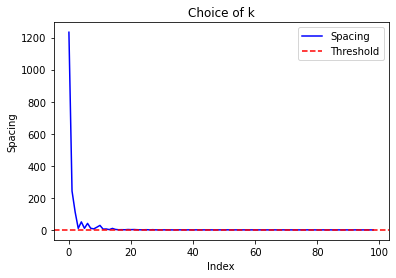

In [10]:
# Compute the rank-100 SVD of X
U, S, Vt = svd(X, full_matrices=False)
rank_100_singular_values = S[:100]

# Compute the spacings
spacings = rank_100_singular_values[:-1] - rank_100_singular_values[1:]

# Compute the mean and standard deviation of spacings from s_79 to s_99
mean_spacing = np.mean(spacings[78:98])  # Index 78 corresponds to s_79, and index 98 corresponds to s_99
std_spacing = np.std(spacings[78:98])

# Compute the threshold for k
threshold = mean_spacing + 6 * std_spacing

# Find the maximum index i such that s_i > threshold
k = np.argmin(spacings > threshold) + 1  # Adding 1 to convert from index to k

print("Estimated k:", k)

# Plot the spacings and threshold
plt.plot(spacings, 'b-', label='Spacing')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel('Index')
plt.ylabel('Spacing')
plt.legend()
plt.title('Choice of k')
plt.show()

In [11]:
def randomized_svd_py(A, K, q, seed):
    
        U, Sigma, VT = randomized_svd(A, 
                                      n_components=K, 
                                      n_iter=q, 
                                      random_state=seed)
        return U, Sigma, VT

In [12]:
u, s, vh = randomized_svd_py(X, k,10,seed = 24)
X_tsvd = u @ np.diag(s)@ vh
s

array([1953.65712357,  720.55044688,  477.67323418,  365.5238086 ,
        355.91424139,  305.78298941,  295.81978036,  255.07434964,
        244.46785978,  238.10001284,  221.12375455,  192.9571087 ,
        188.03419825,  182.00841065,  180.03110355,  170.61284594,
        167.5575624 ,  166.34048931,  164.46712943,  163.79337016,
        160.86761281,  159.02090912,  156.20454221,  154.4839143 ])

## Thresholding

In [13]:
def threshold_gene_expression(matrix):
    """Perform thresholding operation on a gene expression matrix."""
    row_max = np.max(matrix, axis=1)  # Compute the average value for each row
    threshold = 0.1 * row_max  # Calculate the threshold as 0.01 times the average value

    thresholded_matrix = np.where(matrix < threshold[:, np.newaxis], 0, matrix)
    # Set values lower than the threshold to zero

    return thresholded_matrix

In [14]:
X_tsvd_thre = threshold_gene_expression(X_tsvd)

## Calculate the error

In [15]:
def zero_positions(matrix):
    # Get the positions of zeros in the matrix
    return set(zip(*np.where(matrix == 0)))

def compare_zero_positions(X, X_shift_recover):
    # Initialize variables
    total_zeros = 0
    correct_zeros = 0

    # Iterate through the matrices in chunks
    chunk_size = 1000  # Adjust the chunk size as per your memory constraints
    for i in range(0, X.shape[0], chunk_size):
        X_chunk = X[i:i+chunk_size]
        X_shift_recover_chunk = X_shift_recover[i:i+chunk_size]

        # Get the zero positions in each chunk
        X_zero_positions = zero_positions(X_chunk)
        X_shift_recover_zero_positions = zero_positions(X_shift_recover_chunk)

        # Update the counts
        total_zeros += len(X_zero_positions)
        correct_zeros += len(X_zero_positions & X_shift_recover_zero_positions)

    # Calculate the ratio of correctly recovered zeros
    if total_zeros != 0:  # Avoid division by zero
        ratio = correct_zeros / total_zeros
    else:
        ratio = None  # Or define another behavior for this case

    return ratio

In [16]:
ratio = compare_zero_positions(X, X_tsvd_thre)
print(ratio)

0.7817166484185453
